In [1]:
import os
import h5py
import time
import csv
import glob

import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import tensorflow as tf
from tensorflow.keras.models import load_model
print(tf.__version__)

import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt 
import seaborn as sns

from keras_dgl.layers import MultiGraphCNN

2.6.0


In [2]:
def get_room_parameters(root_path, iter_index):
    room_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_room.csv"
    open_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_open.csv"
    # read room data
    rm_file = open(room_file_pth,"r")
    param = list(csv.reader(rm_file, delimiter = ','))[:-1]
    param = np.array(param).astype(float)
    rm_file.close()

    op_file = open(open_file_pth,"r")
    openings = list(csv.reader(op_file, delimiter = ','))
    openings = np.array(openings).astype(float)
    op_file.close()
    
    rm_param = (param, openings)    
    return rm_param

In [3]:
# this function only process vertical openings
def find_edge_WSEN_and_shift(rm_center, rm_dim, edge):
    WSEN = [0,0,0,0]
    h_shift, v_shift = 0.0, 0.0
    edge_cx, edge_cy, edge_cz = (edge[0]+edge[1])/2.0, (edge[2]+edge[3])/2.0, (edge[4]+edge[5])/2.0
    rm_cx, rm_cy, rm_cz = rm_center[0], rm_center[1], rm_center[2]
    rm_dimx, rm_dimy, rm_dimz = rm_dim[0], rm_dim[1], rm_dim[2]
    if edge[0]==edge[1]: #the opening is on west or east walls (on a yz plane)
        h_shift = (edge_cy-rm_cy)/rm_dimy
        v_shift = (edge_cz-rm_cz)/rm_dimz
        if edge[0] >= rm_center[0]:
            WSEN = [0,0,1,0] #east
        else:
            WSEN = [1,0,0,0] #west
    else: #the opening is on north or south walls (on a xz plane)
        h_shift = (edge_cx-rm_cx)/rm_dimx
        v_shift = (edge_cz-rm_cz)/rm_dimz
        if edge[2] >= rm_center[1]:
            WSEN = [0,0,0,1] #north
        else:
            WSEN = [0,1,0,0] #south
    return WSEN, h_shift, v_shift

def Node_and_Edge_Generator(rm_param):
    rooms, openings = rm_param
    
    num_rm = len(rooms)
    room_mx = np.zeros((4+num_rm, 7))
    ext_dimx = max(rooms[:,1])-min(rooms[:,0])
    ext_dimy = max(rooms[:,3])-min(rooms[:,2])
    ext_dimz = max(rooms[:,5])-min(rooms[:,4])
    ext_cx, ext_cy, ext_cz = (max(rooms[:,1])+min(rooms[:,0]))/2.0,(max(rooms[:,3])+min(rooms[:,2]))/2.0, (max(rooms[:,5])+min(rooms[:,4]))/2.0
    rm_centers = []
    rm_dims = []

    room_mx[0,3] = 1 #West
    room_mx[1,4] = 1 #South
    room_mx[2,5] = 1 #East
    room_mx[3,6] = 1 #North
    for i,rm in enumerate(rooms):
        x_dim = rm[1]-rm[0]
        y_dim = rm[3]-rm[2]
        z_dim = rm[5]-rm[4]
        area = x_dim * y_dim
        rm_centers.append([(rm[0]+rm[1])/2.0, (rm[2]+rm[3])/2.0, (rm[4]+rm[5])/2.0])
        rm_dims.append([x_dim, y_dim, z_dim])
        W, S, E, N = 0, 0, 0, 0
        room_mx[i+4,:] = [x_dim, y_dim, area, W, S, E, N]

    edge_mx = np.zeros((9, 4+num_rm, 4+num_rm))
    for op in openings:
        ind_a, ind_b = int(op[6]), int(op[7])
        cx, cy, cz = (op[0]+op[1])/2.0, (op[2]+op[3])/2.0, (op[4]+op[5])/2.0
        h_dim = max(np.abs(op[1]-op[0]), np.abs(op[3]-op[2]))
        v_dim = np.abs(op[5]-op[4])
        area = h_dim*v_dim

        WSEN_a = [0,0,0,0]
        h_shift_a, v_shift_a = 0.0, 0.0
        if ind_a == -1: #North, on the south face
            h_shift_a = (cx-ext_cx)/ext_dimx
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [0,1,0,0]
        elif ind_a == -2: #East, on the west face
            h_shift_a = (cy-ext_cy)/ext_dimy
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [1,0,0,0]
        elif ind_a == -3: #South, on the north face
            h_shift_a = (cx-ext_cx)/ext_dimx
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [0,0,0,1]
        elif ind_a == -4: #West, on the east face
            h_shift_a = (cy-ext_cy)/ext_dimy
            v_shift_a = (cz-ext_cz)/ext_dimz
            WSEN_a = [0,0,1,0]
        else:
            rm_center = rm_centers[ind_a]
            rm_dim = rm_dims[ind_a]
            WSEN_a, h_shift_a, v_shift_a = find_edge_WSEN_and_shift(rm_center, rm_dim, op)

        WSEN_b = [0,0,0,0]
        h_shift_b, v_shift_b = 0.0, 0.0
        if ind_b == -1: #North, on the south face
            h_shift_b = (cx-ext_cx)/ext_dimx
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [0,1,0,0]
        elif ind_b == -2: #East, on the west face
            h_shift_b = (cy-ext_cy)/ext_dimy
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [1,0,0,0]
        elif ind_b == -3: #South, on the north face
            h_shift_b = (cx-ext_cx)/ext_dimx
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [0,0,0,1]
        elif ind_b == -4: #West, on the east face
            h_shift_b = (cy-ext_cy)/ext_dimy
            v_shift_b = (cz-ext_cz)/ext_dimz
            WSEN_b = [0,0,1,0]
        else:
            rm_center = rm_centers[ind_b]
            rm_dim = rm_dims[ind_b]
            WSEN_b, h_shift_b, v_shift_b = find_edge_WSEN_and_shift(rm_center, rm_dim, op)

        edge_mx[:, ind_a+4, ind_b+4] = [h_dim, v_dim, area, round(h_shift_a,4), round(v_shift_a,4)] + WSEN_a
        edge_mx[:, ind_b+4, ind_a+4] = [h_dim, v_dim, area, round(h_shift_b,4), round(v_shift_b,4)] + WSEN_b
    return room_mx, edge_mx

In [4]:
def normalize_adj_numpy(adj, symmetric=False):
    if symmetric:
        d = np.diag(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d)
    else:
        d = np.diag(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj)
    return a_norm

def preprocess_adj_tensor_concat(adj_tensor, symmetric=False):
    adj_out_tensor = []
    for i in range(adj_tensor.shape[0]):
        adj = adj_tensor[i]
        ################################
        # adj = adj + np.eye(adj.shape[0])
        ################################
        # adj = normalize_adj_numpy(adj, symmetric)
        ################################
        adj_out_tensor.append(adj)
    adj_out_tensor = np.concatenate(adj_out_tensor, axis=0)
    return adj_out_tensor

def preprocess_edge_adj_tensor(edge_adj_tensor, symmetric=False):
    edge_adj_out_tensor = []
    num_edge_features = edge_adj_tensor.shape[3]

    for i in range(edge_adj_tensor.shape[0]):
        edge_adj = edge_adj_tensor[i]
        edge_adj = np.array(edge_adj)
        edge_adj = preprocess_adj_tensor_concat(edge_adj, symmetric)
        edge_adj_out_tensor.append(edge_adj)

    edge_adj_out_tensor = np.array(edge_adj_out_tensor)
    return edge_adj_out_tensor

In [5]:
# Create DataFrame to store the floor plan boundary
# This is the prediction version and the flow direction info at each window is unknown in open.csv file
# The flow direction info is in in_out_mx input
def create_ext_bnd_matrix(rm_param, in_out_mx, ext_nxy, ext_nz, res):
    param, openings = rm_param
    
    x0_min = min([float(param[i][0]) for i in range(len(param))])
    x1_max = max([float(param[i][1]) for i in range(len(param))])
    y0_min = min([float(param[i][2]) for i in range(len(param))])
    y1_max = max([float(param[i][3]) for i in range(len(param))])
    x_length, y_length= abs(x1_max-x0_min), abs(y1_max-y0_min)
    
    x_start = x0_min - round((ext_nxy-x_length/res)/3.0)*res + res/2.0
    y_start = y0_min - round((ext_nxy-y_length/res)/2.0)*res + res/2.0
    z_start = 0.0 + res/2.0
    
    def build_coord_array_ext(x_l, x_h, y_l, y_h, z_l, z_h, x_s, y_s, z_s, resolution):
        x_range = ((np.arange(x_l+resolution/2., x_h, resolution)-x_s)/resolution).round(0).astype(int)
        y_range = ((np.arange(y_l+resolution/2., y_h, resolution)-y_s)/resolution).round(0).astype(int)
        z_range = ((np.arange(z_l+resolution/2., z_h, resolution)-z_s)/resolution).round(0).astype(int)
        x_arr, y_arr, z_arr = np.meshgrid(x_range, y_range, z_range)
        return x_arr.flatten(), y_arr.flatten(), z_arr.flatten()
    
    x_ext_arr, y_ext_arr, z_ext_arr = build_coord_array_ext(x0_min, x1_max, y0_min, y1_max, 0.0, 3.0, x_start, y_start, z_start, res)
    x_offset_arr, y_offset_arr, z_offset_arr = build_coord_array_ext(x0_min-res, x1_max+res, y0_min-res, y1_max+res, 0.0, 3.0+res, x_start, y_start, z_start, res)
    bnd_df = pd.DataFrame({'x':x_ext_arr, 'y':y_ext_arr, 'z':z_ext_arr})
    
    bnd = np.ones((ext_nxy, ext_nxy, ext_nz))*0.2
    bnd[bnd_df.x, bnd_df.y, bnd_df.z] = 0.1
    
    mask = np.ones((ext_nxy,ext_nxy,ext_nz))
    mask[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    
    ext_bnd_comp = np.ones((ext_nxy, ext_nxy, ext_nz))*0.05
    ext_bnd_comp[x_offset_arr, y_offset_arr, z_offset_arr] = 0.6
    ext_bnd_comp[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    
    for opening in openings:
        if opening[6] == -1 or opening[7] == -1:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3]+res, opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array_ext(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            other_ind = int(opening[6] + opening[7] - (-1))
            if abs(in_out_mx[-1+4, other_ind+4] - 1.0) > 0.01:
                bnd[x_array, y_array, z_array] = 1.1
                ext_bnd_comp[x_array, y_array, z_array] = 1.0
            else:
                bnd[x_array, y_array, z_array] = -0.9
                ext_bnd_comp[x_array, y_array, z_array] = -1.0
        elif opening[6] == -2 or opening[7] == -2:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1]+res, opening[2], opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array_ext(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            other_ind = int(opening[6] + opening[7] - (-2))
            if abs(in_out_mx[-2+4, other_ind+4] - 1.0) > 0.01:
                bnd[x_array, y_array, z_array] = 1.1
                ext_bnd_comp[x_array, y_array, z_array] = 1.0
            else:
                bnd[x_array, y_array, z_array] = -0.9
                ext_bnd_comp[x_array, y_array, z_array] = -1.0
        elif opening[6] == -3 or opening[7] == -3:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2]-res, opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array_ext(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            other_ind = int(opening[6] + opening[7] - (-3))
            if abs(in_out_mx[-3+4, other_ind+4] - 1.0) > 0.01:
                bnd[x_array, y_array, z_array] = 1.1
                ext_bnd_comp[x_array, y_array, z_array] = 1.0
            else:
                bnd[x_array, y_array, z_array] = -0.9
                ext_bnd_comp[x_array, y_array, z_array] = -1.0
        elif opening[6] == -4 or opening[7] == -4:
            xl, xh, yl, yh, zl, zh = opening[0]-res, opening[1], opening[2], opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array_ext(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            other_ind = int(opening[6] + opening[7] - (-4))
            if abs(in_out_mx[-4+4, other_ind+4] - 1.0) > 0.01:
                bnd[x_array, y_array, z_array] = 1.1
                ext_bnd_comp[x_array, y_array, z_array] = 1.0
            else:
                bnd[x_array, y_array, z_array] = -0.9
                ext_bnd_comp[x_array, y_array, z_array] = -1.0
    
    bnd = bnd.astype('float32',casting='same_kind')
    mask = mask.astype('float32',casting='same_kind')
    feature = np.stack([bnd, mask], axis=-1)
    
    return feature, ext_bnd_comp

In [6]:
# Create DataFrame to store the current room's boundary
# This is the prediction version and only for the current single one room
# The flow direction info is in in_out_mx input
def create_int_bnd_matrix(rm_param, rm_ind, in_out_mx, inlet_dfs, nxy, nz, res):
    param, openings = rm_param
    
    def build_coord_array_int(opening, resolution):
        xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3], opening[4], opening[5]
        x_range = np.arange(xl, xh + resolution, resolution)
        y_range = np.arange(yl, yh + resolution, resolution)
        z_range = np.arange(zl, zh + resolution, resolution)
        x_arr, y_arr, z_arr = np.meshgrid(x_range, y_range, z_range)
        return x_arr.flatten(), y_arr.flatten(), z_arr.flatten()
    
    x_ori = np.arange(param[rm_ind][0], param[rm_ind][1]+res, res)
    y_ori = np.arange(param[rm_ind][2], param[rm_ind][3]+res, res)
    z_ori = np.arange(param[rm_ind][4], param[rm_ind][5]+res, res)
    x_ori, y_ori, z_ori = np.meshgrid(x_ori, y_ori, z_ori)
    x_ori, y_ori, z_ori = x_ori.flatten(), y_ori.flatten(), z_ori.flatten()
    u_ori, v_ori, w_ori, p_ori, pat_ori = np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape)
    df_ori = pd.DataFrame({"x":x_ori, "y":y_ori, "z":z_ori, "u":u_ori, "v":v_ori, "w":w_ori, "p":p_ori})
    df_pat_ori = pd.DataFrame({"x":x_ori, "y":y_ori, "z":z_ori, "pattern":pat_ori})
    
    in_df = inlet_dfs[rm_ind]
    in_df = in_df.round({'x': 3, 'y': 3, 'z': 3})
    if len(in_df) == 0:
        print("Inlet dataframe contains no information! ")
    
    io_list = in_out_mx.copy()[:, rm_ind+4]
    for opening in openings:
        if opening[6] == rm_ind or opening[7] == rm_ind:
            x_array, y_array, z_array = build_coord_array_int(opening, res)
            other_ind = int(opening[6] + opening[7] - rm_ind)
            if io_list[other_ind+4] == 1:
                for i in range(len(x_array)):
                    df_pat_ori.loc[(df_pat_ori.x == x_array[i]) & (df_pat_ori.y == y_array[i]) & (df_pat_ori.z == z_array[i]), "pattern"] = -1.0
            else:
                xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3], opening[4], opening[5]
                xl, xh = (xl-0.001, xh+0.001) if xl == xh else (xl+0.001, xh-0.001)
                yl, yh = (yl-0.001, yh+0.001) if yl == yh else (yl+0.001, yh-0.001)
                zl, zh = (zl-0.001, zh+0.001) if zl == zh else (zl+0.001, zh-0.001)
                drop_index = df_ori.loc[(df_ori['x'] > xl) & (df_ori['x'] < xh) & (df_ori['y'] > yl) & (df_ori['y'] < yh) & (df_ori['z'] > zl) & (df_ori['z'] < zh)].index
                df_ori.drop(drop_index, inplace=True)
                df_ori.reset_index(drop=True, inplace=True)
                for i in range(len(x_array)):
                    df_pat_ori.loc[(df_pat_ori.x == x_array[i]) & (df_pat_ori.y == y_array[i]) & (df_pat_ori.z == z_array[i]), "pattern"] = 1.0

    df_ori = pd.concat([df_ori, in_df], ignore_index=True)
    
    xi, dx = np.linspace(param[rm_ind][0], param[rm_ind][1], nxy, retstep=True)
    yi, dy = np.linspace(param[rm_ind][2], param[rm_ind][3], nxy, retstep=True)
    zi, dz = np.linspace(param[rm_ind][4], param[rm_ind][5], nz, retstep=True)
    xi, yi, zi = np.meshgrid(xi, yi, zi)
    xi = np.concatenate((xi[(0,-1),:,:].flatten(), xi[1:-1,(0,-1),:].flatten()))
    yi = np.concatenate((yi[(0,-1),:,:].flatten(), yi[1:-1,(0,-1),:].flatten()))
    zi = np.concatenate((zi[(0,-1),:,:].flatten(), zi[1:-1,(0,-1),:].flatten()))
    
    ui = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.u, (xi, yi, zi), method='linear')
    vi = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.v, (xi, yi, zi), method='linear')
    wi = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.w, (xi, yi, zi), method='linear')
    pi = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.p, (xi, yi, zi), method='linear')
    pati = griddata((df_pat_ori.x, df_pat_ori.y, df_pat_ori.z), df_pat_ori.pattern, (xi, yi, zi), method='linear')
        
    dfi = pd.DataFrame({"xi":xi, "yi":yi, "zi":zi, "ui":ui, "vi":vi, "wi":wi, "pi":pi, "pati":pati})
    dfi['xi'] = (dfi['xi']-param[rm_ind][0])/dx
    dfi['yi'] = (dfi['yi']-param[rm_ind][2])/dy
    dfi['zi'] = (dfi['zi']-param[rm_ind][4])/dz

    dfi = dfi.round({'xi': 0, 'yi': 0, 'zi': 0, 'ui': 6, 'vi': 6, 'wi': 6, 'pi': 6})
    dfi.loc[(dfi['pati'] != 1.0) & (dfi['pati'] != -1.0), 'pati'] = 0.0
    dfi[['xi', 'yi', 'zi']] = dfi[['xi', 'yi', 'zi']].astype(int)
    dfi.loc[((dfi['xi'] == 0.0) | (dfi['xi'] == nxy-1.0)) & ((dfi['yi'] == 0.0) | (dfi['yi'] == nxy-1.0)), 'pati'] = 0.0
    dfi.loc[((dfi['xi'] == 0.0) | (dfi['xi'] == nxy-1.0)) & ((dfi['zi'] == 0.0) | (dfi['zi'] == nz-1.0)), 'pati'] = 0.0
    dfi.loc[((dfi['yi'] == 0.0) | (dfi['yi'] == nxy-1.0)) & ((dfi['zi'] == 0.0) | (dfi['zi'] == nz-1.0)), 'pati'] = 0.0

    bnd = np.zeros((nxy, nxy, nz, 5)) # 5 channel: u, v, w, p, pattern
    bnd[dfi.xi, dfi.yi, dfi.zi, 0] = dfi.ui
    bnd[dfi.xi, dfi.yi, dfi.zi, 1] = dfi.vi
    bnd[dfi.xi, dfi.yi, dfi.zi, 2] = dfi.wi
    bnd[dfi.xi, dfi.yi, dfi.zi, 3] = dfi.pi
    bnd[dfi.xi, dfi.yi, dfi.zi, 4] = dfi.pati
    bnd[1:-1, 1:-1, 1:-1, :4] = 0.0
    bnd[1:-1, 1:-1, 1:-1, 4] = 0.5

    bnd = bnd.astype('float32',casting='same_kind')
    dxyz = np.array([dx, dy, dz]).astype('float32',casting='same_kind')
    
    return bnd, dxyz

In [7]:
def fit_rm_in_position(rm_param, rm_ind, rm_pred_mx, dxyz, in_out_mx, ext_nxy, ext_nz, nxy, nz, res):
    param, openings = rm_param
    dx, dy, dz = dxyz[0], dxyz[1], dxyz[2]
    
    x0_min = min([float(param[i][0]) for i in range(len(param))])
    x1_max = max([float(param[i][1]) for i in range(len(param))])
    y0_min = min([float(param[i][2]) for i in range(len(param))])
    y1_max = max([float(param[i][3]) for i in range(len(param))])
    x_length, y_length= abs(x1_max-x0_min), abs(y1_max-y0_min)
    
    x_start = x0_min - round((ext_nxy-x_length/res)/3.0)*res + res/2.0
    y_start = y0_min - round((ext_nxy-y_length/res)/2.0)*res + res/2.0
    z_start = 0.0 + res/2.0
    
    def build_coord_array(x_l, x_h, y_l, y_h, z_l, z_h, x_s, y_s, z_s, resolution):
        x_range = ((np.arange(x_l+resolution/2., x_h, resolution)-x_s)/resolution).round(0).astype(int)
        y_range = ((np.arange(y_l+resolution/2., y_h, resolution)-y_s)/resolution).round(0).astype(int)
        z_range = ((np.arange(z_l+resolution/2., z_h, resolution)-z_s)/resolution).round(0).astype(int)
        x_arr, y_arr, z_arr = np.meshgrid(x_range, y_range, z_range)
        return x_arr.flatten(), y_arr.flatten(), z_arr.flatten()
    
    def create_opening_arrays(opening, rm_center, x_s, y_s, z_s, resolution):
        xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3], opening[4], opening[5]
        # shift the opening inside the boundary wall
        if xl == xh:
            if xh < rm_center[0]:
                xh = xh + resolution
            else:
                xl = xl - resolution
        elif yl == yh:
            if yh < rm_center[1]:
                yh = yh + resolution
            else:
                yl = yl - resolution
        else:
            if zh < rm_center[2]:
                yh = yh + resolution
            else:
                yl = yl - resolution
        return build_coord_array(xl, xh, yl, yh, zl, zh, x_s, y_s, z_s, resolution)
    
    rxl, rxh, ryl, ryh, rzl, rzh = param[rm_ind][0], param[rm_ind][1], param[rm_ind][2], param[rm_ind][3], param[rm_ind][4], param[rm_ind][5]
    rm_c = [(rxl+rxh)/2.0, (ryl+ryh)/2.0, (rzl+rzh)/2.0]
    x_rm_arr, y_rm_arr, z_rm_arr = build_coord_array(rxl, rxh, ryl, ryh, rzl, rzh, x_start, y_start, z_start, res)
    x_in_arr, y_in_arr, z_in_arr = build_coord_array(rxl+res, rxh-res, ryl+res, ryh-res, rzl+res, rzh-res, x_start, y_start, z_start, res)
    bnd_df = pd.DataFrame({'x':x_rm_arr, 'y':y_rm_arr, 'z':z_rm_arr})
    inner_bnd_df = pd.DataFrame({'x':x_in_arr, 'y':y_in_arr, 'z':z_in_arr})
    
    bnd = np.zeros((ext_nxy, ext_nxy, ext_nz))
    bnd[bnd_df.x, bnd_df.y, bnd_df.z] = 0.3
    bnd[inner_bnd_df.x, inner_bnd_df.y, inner_bnd_df.z] = 0.1
    
    io_list = in_out_mx.copy()[:, rm_ind+4]
    for opening in openings:
        if opening[6] == rm_ind or opening[7] == rm_ind:
            x_array, y_array, z_array = create_opening_arrays(opening, rm_c, x_start, y_start, z_start, res)
            other_ind = int(opening[6] + opening[7] - rm_ind)
            if io_list[other_ind+4] == 1:
                bnd[x_array, y_array, z_array] = -1.0
            else:
                bnd[x_array, y_array, z_array] = 1.0
    bnd = bnd.astype('float32',casting='same_kind')
    
    xi = np.arange(rxl+res/2., rxh, res)
    yi = np.arange(ryl+res/2., ryh, res)
    zi = np.arange(rzl+res/2., rzh, res)
    xi, yi, zi = np.meshgrid(xi, yi, zi)
    xi, yi, zi = xi.flatten(), yi.flatten(), zi.flatten()
    
    xn, yn, zn = np.meshgrid(range(nxy), range(nxy), range(nz))
    xn, yn, zn = xn.flatten(), yn.flatten(), zn.flatten()
    dfn = pd.DataFrame({'x':xn, 'y':yn, 'z':zn, 'u':rm_pred_mx[xn, yn, zn, 0], 'v':rm_pred_mx[xn, yn, zn, 1], 'w':rm_pred_mx[xn, yn, zn, 2], 'p':rm_pred_mx[xn, yn, zn, 3]})
    dfn['x'] = dfn['x']*dx + rxl
    dfn['y'] = dfn['y']*dy + ryl
    dfn['z'] = dfn['z']*dz + rzl
    
    ui = griddata((dfn.x, dfn.y, dfn.z), dfn.u, (xi, yi, zi), method='nearest')
    vi = griddata((dfn.x, dfn.y, dfn.z), dfn.v, (xi, yi, zi), method='nearest')
    wi = griddata((dfn.x, dfn.y, dfn.z), dfn.w, (xi, yi, zi), method='nearest')
    pi = griddata((dfn.x, dfn.y, dfn.z), dfn.p, (xi, yi, zi), method='nearest')
    
    dfi = pd.DataFrame({"xi":xi, "yi":yi, "zi":zi, "ui":ui, "vi":vi, "wi":wi, "pi":pi})
    dfi['xi'] = (dfi['xi']-x_start)/res
    dfi['yi'] = (dfi['yi']-y_start)/res
    dfi['zi'] = (dfi['zi']-z_start)/res
    dfi = dfi.round({'xi': 0, 'yi': 0, 'zi': 0, 'ui': 6, 'vi': 6, 'wi': 6, 'pi': 6})
    dfi[['xi', 'yi', 'zi']] = dfi[['xi', 'yi', 'zi']].astype(int)

    rm_pred_inpos = np.zeros((ext_nxy, ext_nxy, ext_nz, 4))
    rm_pred_inpos[dfi.xi, dfi.yi, dfi.zi, 0] = dfi.ui
    rm_pred_inpos[dfi.xi, dfi.yi, dfi.zi, 1] = dfi.vi
    rm_pred_inpos[dfi.xi, dfi.yi, dfi.zi, 2] = dfi.wi
    rm_pred_inpos[dfi.xi, dfi.yi, dfi.zi, 3] = dfi.pi
    
    return rm_pred_inpos, bnd

In [8]:
def inlet_dataframe_update(rm_param, inlet_dfs, cur_inds, in_out_mx, pred_mx, bnd_mx, ext_nxy, res):
    param, openings = rm_param
    new_inlet_dfs = inlet_dfs.copy()
    dict_op = {tuple(np.sort([openings[i,6], openings[i,7]])): tuple(openings[i,:6]) for i in range(len(openings))}
    
    x0_min = min([float(param[i][0]) for i in range(len(param))])
    x1_max = max([float(param[i][1]) for i in range(len(param))])
    y0_min = min([float(param[i][2]) for i in range(len(param))])
    y1_max = max([float(param[i][3]) for i in range(len(param))])
    x_length, y_length= abs(x1_max-x0_min), abs(y1_max-y0_min)
    
    x_start = x0_min - round((ext_nxy-x_length/res)/3.0)*res + res/2.0
    y_start = y0_min - round((ext_nxy-y_length/res)/2.0)*res + res/2.0
    z_start = 0.0 + res/2.0
    
    xyz_ind = np.where((bnd_mx == 1.1) | (bnd_mx == -1.0)) # 1.1 for outdoor case and -1.0 for indoor case
    op_uvwp = pred_mx[xyz_ind]
    p_df = pd.DataFrame(np.hstack((np.array(xyz_ind).T, op_uvwp)), columns=['x', 'y', 'z', 'u', 'v', 'w', 'p'])
    p_df['x'] = x_start + p_df['x']*res
    p_df['y'] = y_start + p_df['y']*res
    p_df['z'] = z_start + p_df['z']*res
    for ind in cur_inds:
        in_list = in_out_mx.copy()[4:, ind+4]
        for i in range(len(in_list)):
            if in_list[i] == 1:
                xl, xh, yl, yh, zl, zh = dict_op[tuple(np.sort([ind, i]))]
                dfi = p_df.loc[(p_df['x'].between(xl-0.75*res, xh+0.75*res)) & (p_df['y'].between(yl-0.75*res, yh+0.75*res)) & (p_df['z'].between(zl-0.75*res, zh+0.75*res))]

                xi = np.arange(xl + res/2.0, xh, res) if xl < xh else np.array([xl])
                yi = np.arange(yl + res/2.0, yh, res) if yl < yh else np.array([yl])
                zi = np.arange(zl + res/2.0, zh, res) if zl < zh else np.array([zl])
                xi, yi, zi = np.meshgrid(xi, yi, zi)
                xi, yi, zi = xi.flatten(), yi.flatten(), zi.flatten()
                
                ui = griddata((dfi.x, dfi.y, dfi.z), dfi.u, (xi, yi, zi), method='nearest')
                vi = griddata((dfi.x, dfi.y, dfi.z), dfi.v, (xi, yi, zi), method='nearest')
                wi = griddata((dfi.x, dfi.y, dfi.z), dfi.w, (xi, yi, zi), method='nearest')
                pi = griddata((dfi.x, dfi.y, dfi.z), dfi.p, (xi, yi, zi), method='nearest')
                
                new_df = pd.DataFrame({'x':xi, 'y':yi, 'z':zi, 'u':ui, 'v':vi, 'w':wi, 'p':pi})
                new_inlet_dfs[i] = pd.concat([new_inlet_dfs[i], new_df], ignore_index=True)
                
    return new_inlet_dfs

In [9]:
def Calculate_pred_post(pred, GC_filters):
    pred_post = np.zeros(pred.shape)
    locator = GC_filters[18:27, :]
    rm_dim = pred.shape[0]
    if not pred.shape[0] == pred.shape[1]:
        print("Predicted matrix has different column and row dimensions!")
        
    for i in range(rm_dim):
        for j in range(i+1, rm_dim):
            if not locator[i,j] == 0 and not i==j:
                if pred[i,j] > pred[j,i]:
                    pred_post[i,j] = 1
                    pred_post[j,i] = 0
                elif pred[i,j] < pred[j,i]:
                    pred_post[i,j] = 0
                    pred_post[j,i] = 1
                else:
                    pred_post[i,j] = 0
                    pred_post[j,i] = 0
    
    for i in range(4, pred.shape[0]):
        if sum(pred_post[i,:]) == 0:
            pred_nzero = np.where(locator > 0.0, pred, 0.0)
            j = np.argmax(pred_nzero[i,:])
            pred_post[i,j] = 1
            pred_post[j,i] = 0
  
    return pred_post

In [10]:
def reorder_rooms(in_out_mx):
    reordered_ind = np.array([])
    reordered_ind = reordered_ind.astype(int)
    dim = in_out_mx.shape[0]
    inlet_mx = in_out_mx.copy()[4:, 4:]
    ext_inlet_mx = in_out_mx.copy()[4:, :4]
    init_inds = np.argwhere(np.sum(inlet_mx, axis=1) == 0).flatten()
    if len(init_inds) == 0:
        init_inds = np.argmax(np.sum(ext_inlet_mx, axis=1)).flatten()
        ext_inlet_mx[init_inds[0], :] = 0
    else:
        ext_inlet_mx[init_inds, :] = 0
    reordered_ind = np.concatenate([reordered_ind, init_inds])
    while len(reordered_ind) < dim - 4:
        inlet_mx[:, reordered_ind] = 0
        next_inds = np.argwhere(np.sum(inlet_mx, axis=1) == 0).flatten()
        next_inds = np.array([x for x in next_inds if not x in reordered_ind])
        if len(next_inds) == 0:
            next_inds = np.argmax(np.sum(ext_inlet_mx, axis=1)).flatten()
            next_inds = np.array([x for x in next_inds if not x in reordered_ind])
            print("Unable to find perfect next room, use imperfect choice:", next_inds)
            if np.sum(ext_inlet_mx[next_inds[0], :]) == 0:
                raise Exception("No available inlet (including exterior) is found for the current room!")
            ext_inlet_mx[next_inds[0], :] = 0
        else:
            ext_inlet_mx[init_inds, :] = 0
        reordered_ind = np.concatenate([reordered_ind, next_inds])
    return reordered_ind

In [11]:
# load GCN model
tf.autograph.set_verbosity(0)
GCN_filename = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/07_Combined_Predictor/models/GCN_model_0316_1300.h5"
GCN_model = load_model(GCN_filename, custom_objects={'MultiGraphCNN': MultiGraphCNN}, compile=False)

# load Outdoor model
Outdoor_filename = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/07_Combined_Predictor/models/Outdoor_model_0801_000085.h5"
Outdoor_model = load_model(Outdoor_filename, compile=False)

# load Indoor model
In_mag_filename = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/07_Combined_Predictor/models/Indoor_model_mag_0801_000280.h5"
In_mag_model = load_model(In_mag_filename, compile=False)

In_hres_filename = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/07_Combined_Predictor/models/Indoor_model_uvwp_0801_000225.h5"
In_hres_model = load_model(In_hres_filename, compile=False)

In [12]:
def predict_one_case(root_path, ind, ext_nxy, ext_nz, nxy, nz, delta):
    SYM_NORM = False
    start = time.time()

    # get room dimensions and opening dimensions from the csv files, NOTE: opening csv does not contain flow direction info
    room_param = get_room_parameters(root_path, ind)

    # list of dataframes to store inlet info for each room, in 12345 order
    inlet_dfs = [pd.DataFrame(columns=['x', 'y', 'z', 'u', 'v', 'w', 'p'])]*len(room_param[0])

    print("Now predicting airflow sequence across zones ......")
    # build features for GCN model
    room_matrix, edge_matrix = Node_and_Edge_Generator(room_param)
    room_matrix = np.expand_dims(room_matrix, axis=0)
    edge_matrix = np.expand_dims(edge_matrix, axis=0)

    # build GC filters from edge matrix
    graph_conv_filters = preprocess_edge_adj_tensor(edge_matrix, SYM_NORM)

    # predict in-outlet adjacency matrix
    GCN_start = time.time()
    pred = GCN_model.predict([room_matrix, graph_conv_filters], verbose=None)[0]

    # post processing of adjacency matrix into binary format
    pred_post = Calculate_pred_post(pred, graph_conv_filters[0])
    print("GCN finished prediction in " + str(int(time.time()-GCN_start)) +" seconds.")

    print("Now predicting outdoor flow field ......")
    # build 128*128*32 exterior boundary matrix based on the in-outlet adjacency matrix
    ext_bnd_mx, ext_bnd_compose = create_ext_bnd_matrix(room_param, pred_post, ext_nxy, ext_nz, delta)
    ext_bnd_mx = np.expand_dims(ext_bnd_mx, axis=0)

    # predict outdoor flow pattern based on exterior boundary
    ext_start = time.time()
    ext_pred_mx = Outdoor_model.predict(ext_bnd_mx, verbose=None)
    print("Outdoor model finished prediction in " + str(int(time.time()-ext_start)) +" seconds.")

    # update inlet info into inlet_dfs with predicted outdoor flow pattern
    inlet_dfs = inlet_dataframe_update(room_param, inlet_dfs, [-4, -3, -2, -1], pred_post, ext_pred_mx[0], ext_bnd_mx[0,:,:,:,0], ext_nxy, delta)
    print("Outdoor flow pattern completed ============")
    
    # re-order the rooms according to GCN's in-out sequence prediction
    reordered_rm_inds = reorder_rooms(pred_post)
    print("The order of room index to predict: ", reordered_rm_inds)

    # initialize combined_flow_pattern as ext_pred_mx and then fill all rooms inside the void indoor region
    combined_bnd_pattern = ext_bnd_compose
    combined_flow_pattern = ext_pred_mx[0]

    for rm_ind in reordered_rm_inds:
        print("Now predicting room #" + str(rm_ind) + " ......")
        # create 32*32*16 boundary matrix and the xyz deltas for the current room 
        int_bnd = time.time()
        rm_bnd_mx, xyz_deltas = create_int_bnd_matrix(room_param, rm_ind, pred_post, inlet_dfs, nxy, nz, delta)
        rm_bnd_mx = np.expand_dims(rm_bnd_mx, axis=0)
        xyz_deltas = np.expand_dims(xyz_deltas, axis=0)
        print("Room #" + str(rm_ind) + " indoor bnd mx finished in " + str(int(time.time()-int_bnd)) +" seconds.")
        
        # use the boundary matrix and xyz deltas to predict the velocity magnitude field
        mag_start = time.time()
        rm_mag_mx = In_mag_model.predict([rm_bnd_mx, xyz_deltas], verbose=None)
        print("Room #" + str(rm_ind) + " mag model finished prediction in " + str(int(time.time()-mag_start)) +" seconds.")

        # use the boundary matrix, xyz deltas and magnitude field to predict the u v w p 4 channel flow field
        uvwp_start = time.time()
        rm_pred_mx = In_hres_model.predict([rm_bnd_mx, rm_mag_mx, xyz_deltas], verbose=None)
        print("Room #" + str(rm_ind) + " uvwp model finished prediction in " + str(int(time.time()-uvwp_start)) +" seconds.")

        # rescale the uvwp flow field and put it in overall field position, general the overall field boundary pattern for this room
        rm_pred_inpos, rm_bnd_inpos = fit_rm_in_position(room_param, rm_ind, rm_pred_mx[0], xyz_deltas[0], pred_post, ext_nxy, ext_nz, nxy, nz, delta)
        
        # update inlet info into inlet_dfs with predicted indoor flow pattern for current room
        inlet_dfs = inlet_dataframe_update(room_param, inlet_dfs, [rm_ind], pred_post, rm_pred_inpos, rm_bnd_inpos, ext_nxy, delta)
        
        # add current room flow pattern to the overall flow pattern
        combined_bnd_pattern = combined_bnd_pattern + rm_bnd_inpos
        combined_flow_pattern = combined_flow_pattern + rm_pred_inpos
        print("Room #" + str(rm_ind) + " flow pattern completed ============")
    
    print("Multizone index #" + str(ind) + " complete in " + str(int(time.time()-start)) +" seconds. ==========================================")
    combined_bnd_pattern = np.where((combined_bnd_pattern == 1.0) | (combined_bnd_pattern == -1.0), 0.1, combined_bnd_pattern)
    print("Combined bnd pattern shape: ", combined_bnd_pattern.shape)
    print("Combined flow pattern shape: ", combined_flow_pattern.shape)
    return np.concatenate((np.expand_dims(combined_bnd_pattern, axis=-1), combined_flow_pattern, np.abs(0.9-ext_bnd_mx[0,:,:,:,1:2])), axis=3)

In [13]:
# Create DataFrame to store the CFD result pattern: y
def create_overall_cfd_matrix(root_path, iter_index, ext_nxy, ext_nz, res):
    room_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_room.csv"
    # read room data
    rm_file = open(room_file_pth,"r")
    param = list(csv.reader(rm_file, delimiter = ','))[:-1]
    param = np.array(param).astype(float)
    rm_file.close()
    
    x0_min = min([float(param[i][0]) for i in range(len(param))])
    x1_max = max([float(param[i][1]) for i in range(len(param))])
    y0_min = min([float(param[i][2]) for i in range(len(param))])
    y1_max = max([float(param[i][3]) for i in range(len(param))])
    x_length, y_length= abs(x1_max-x0_min), abs(y1_max-y0_min)
    
    x_start = x0_min - round((ext_nxy-x_length/res)/3.0)*res + res/2.0
    y_start = y0_min - round((ext_nxy-y_length/res)/2.0)*res + res/2.0
    z_start = 0.0 + res/2.0
    
    box_file_pth = root_path + "design_iteration_" + str(iter_index) + "/west/multizone_" + str(iter_index) + ".csv"
    df = pd.read_csv(box_file_pth)
    df = df.drop(columns = "cellnumber").rename(columns={"    x-coordinate": "x", "    y-coordinate": "y", "    z-coordinate": "z", "        pressure": "p", "      x-velocity": "u", "      y-velocity": "v", "      z-velocity": "w"})
    df['x'] = (df['x']-x_start)/res
    df['y'] = (df['y']-y_start)/res
    df['z'] = (df['z']-z_start)/res
    df = df.round({'x': 0, 'y': 0, 'z': 0})
    df[list("xyz")] = df[list("xyz")].astype(int)

    u = np.zeros((ext_nxy, ext_nxy, int(ext_nxy/2)))
    v = np.zeros((ext_nxy, ext_nxy, int(ext_nxy/2)))
    w = np.zeros((ext_nxy, ext_nxy, int(ext_nxy/2)))
    p = np.zeros((ext_nxy, ext_nxy, int(ext_nxy/2)))

    u[df.x, df.y, df.z] = df.u 
    v[df.x, df.y, df.z] = df.v
    w[df.x, df.y, df.z] = df.w
    p[df.x, df.y, df.z] = df.p

    u = u[:, :, :ext_nz].astype('float32',casting='same_kind')
    v = v[:, :, :ext_nz].astype('float32',casting='same_kind')
    w = w[:, :, :ext_nz].astype('float32',casting='same_kind')
    p = p[:, :, :ext_nz].astype('float32',casting='same_kind')
    mx = np.stack([u,v,w,p], axis=-1)
    
    return mx

In [15]:
origin_path = "E:/00_Data_Generator/CFD_result_data/"
root_path = "C:/Users/Xiaoshi/Desktop/00_Data_Generator/Indoor_Dataset_E_0801/"
delta = 0.25
ext_nxy = 128
ext_nz = 32
nxy = 32
nz = 16
# indices = range(2637, 3000)
indices = [2636]
for ind in indices:
    combined_bnd_cfd = predict_one_case(origin_path, ind, ext_nxy, ext_nz, nxy, nz, delta)
    gtruth_mx = create_overall_cfd_matrix(origin_path, ind, ext_nxy, ext_nz, delta)
    npz_file_name = root_path + "overall_iteration_" + str(ind) + ".npz"
    np.savez_compressed(npz_file_name, combined_bnd_cfd, gtruth_mx)
    print("data point " + str(ind) + " complete")

Now predicting airflow sequence across zones ......
GCN finished prediction in 2 seconds.
Now predicting outdoor flow field ......
Outdoor model finished prediction in 15 seconds.
Outdoor flow pattern completed ============
The order of room index to predict:  [0 1 2 4 3]
Now predicting room #0 ......
Room #0 indoor bnd mx finished in 3 seconds.
Room #0 mag model finished prediction in 3 seconds.
Room #0 uvwp model finished prediction in 0 seconds.
Room #0 flow pattern completed ============
Now predicting room #1 ......
Room #1 indoor bnd mx finished in 4 seconds.
Room #1 mag model finished prediction in 0 seconds.
Room #1 uvwp model finished prediction in 0 seconds.
Room #1 flow pattern completed ============
Now predicting room #2 ......
Room #2 indoor bnd mx finished in 2 seconds.
Room #2 mag model finished prediction in 0 seconds.
Room #2 uvwp model finished prediction in 0 seconds.
Room #2 flow pattern completed ============
Now predicting room #4 ......
Room #4 indoor bnd mx fin

In [7]:
root_path = "C:/Users/Xiaoshi/Desktop/00_Data_Generator/Indoor_Dataset_E_0801/"
iter_index = 2997
folder_path = root_path + "overall_iteration_" + str(iter_index) + ".npz"
data = np.load(folder_path)
feature, label= data['arr_0'], data['arr_1']
print("feature shape: ", feature.shape)
print("label shape: ", label.shape)

feature shape:  (128, 128, 32, 6)
label shape:  (128, 128, 32, 4)


(0.0, 1.0, 0.0, 1.0)

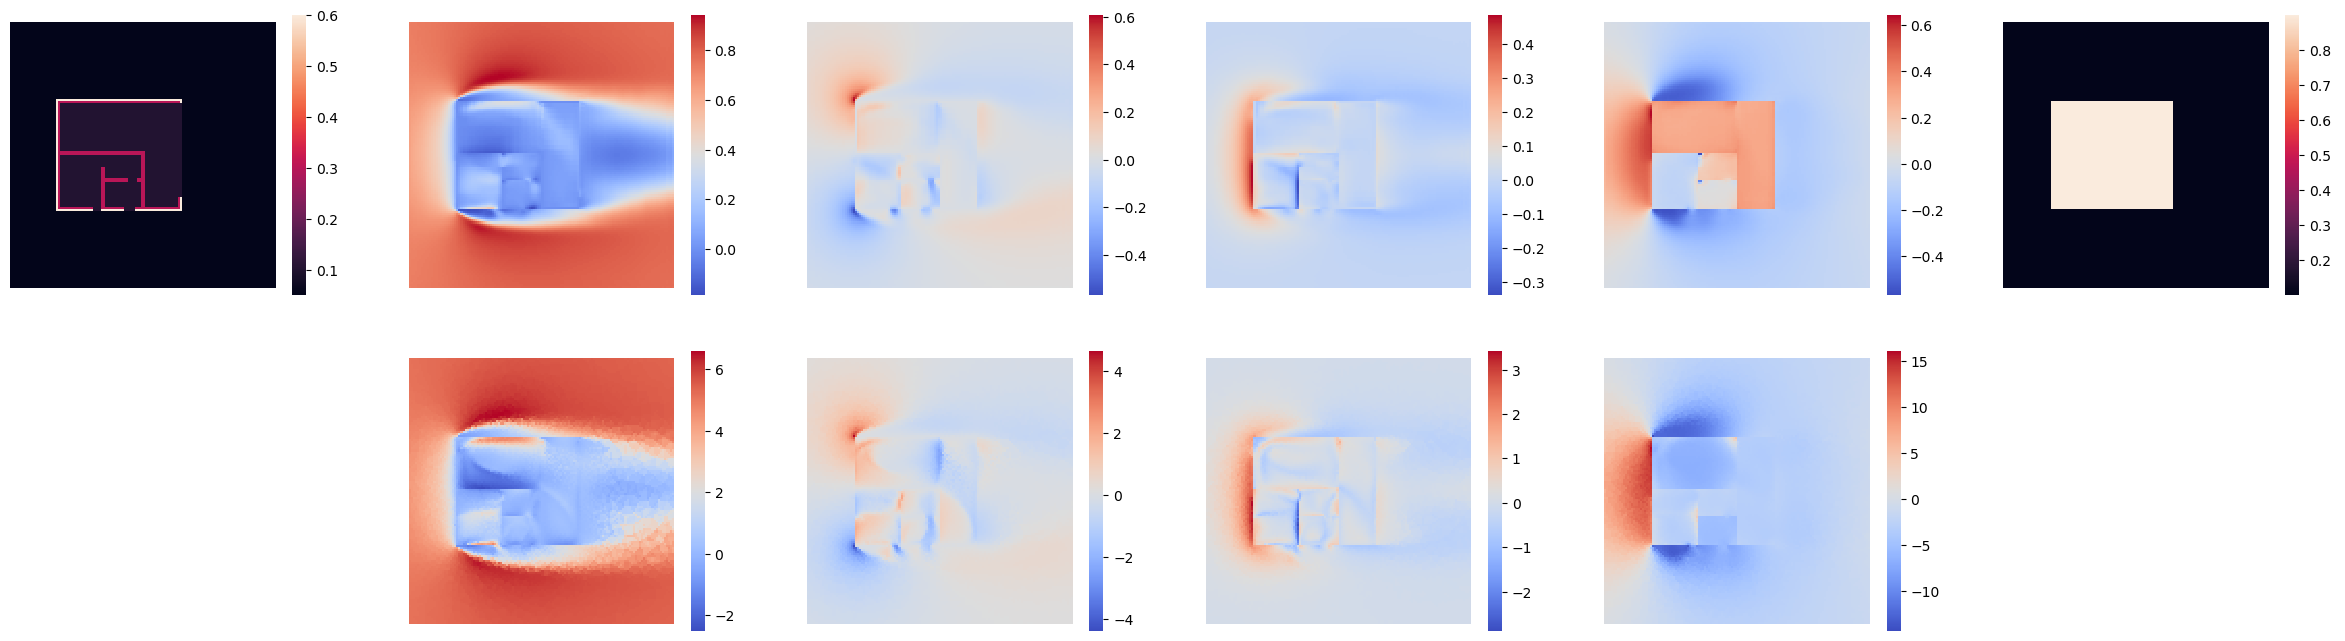

In [8]:
z = 9
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(30, 8))
sns.heatmap(feature[:,:,z,0].T, ax = ax[0,0], square = True)
ax[0,0].invert_yaxis()
ax[0,0].axis('off')
sns.heatmap(feature[:,:,z,1].T, ax = ax[0,1], square = True, cmap="coolwarm")
ax[0,1].invert_yaxis()
ax[0,1].axis('off')
sns.heatmap(feature[:,:,z,2].T, ax = ax[0,2], square = True, cmap="coolwarm")
ax[0,2].invert_yaxis()
ax[0,2].axis('off')
sns.heatmap(feature[:,:,z,3].T, ax = ax[0,3], square = True, cmap="coolwarm")
ax[0,3].invert_yaxis()
ax[0,3].axis('off')
sns.heatmap(feature[:,:,z,4].T, ax = ax[0,4], square = True, cmap="coolwarm")
ax[0,4].invert_yaxis()
ax[0,4].axis('off')
sns.heatmap(feature[:,:,z,5].T, ax = ax[0,5], square = True)
ax[0,5].invert_yaxis()
ax[0,5].axis('off')

ax[1,0].axis('off')
sns.heatmap(label[:,:,z,0].T, ax = ax[1,1], square = True, cmap="coolwarm")
ax[1,1].invert_yaxis()
ax[1,1].axis('off')
sns.heatmap(label[:,:,z,1].T, ax = ax[1,2], square = True, cmap="coolwarm")
ax[1,2].invert_yaxis()
ax[1,2].axis('off')
sns.heatmap(label[:,:,z,2].T, ax = ax[1,3], square = True, cmap="coolwarm")
ax[1,3].invert_yaxis()
ax[1,3].axis('off')
sns.heatmap(label[:,:,z,3].T, ax = ax[1,4], square = True, cmap="coolwarm")
ax[1,4].invert_yaxis()
ax[1,4].axis('off')
ax[1,5].axis('off')